In [1]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Sep 26 09:27 kaggle.json


In [2]:
!kaggle datasets download -d gargmanas/movierecommenderdataset

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 127MB/s]


In [3]:
!unzip movierecommenderdataset.zip

Archive:  movierecommenderdataset.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Data Understanding

In [5]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

Data terbagi menjadi dua bagian, yaitu: 
- Movies: berisi daftar film beserta genre nya. Terdapat pada file movies.csv
- Ratings: berisi daftar ID user, ID film dan rating yang diberikan oleh user. Terdapat pada file ratings.csb  

In [6]:
print('jumlah data movies:   ', len(movies.movieId.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(ratings.userId.unique()))
print('Jumlah data penilaian movies: ', len(ratings.movieId.unique()))

jumlah data movies:    9742
Jumlah data penilaian yang diberikan pengguna:  610
Jumlah data penilaian movies:  9724


## Movies

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Variabel-variabel pada Movies Recommendations dataset pada file movies.csv adalah sebagai berikut:
- Movieid : id dari Movies.
- title : nama dari Movies.
- genres : genre dari Movies yang dipisahkan oleh vertical bar( | ).

In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan output diatas, didapatkan informasi bahwa:
- tipe data dari kolom movieId yaitu int64, sedangkan tipe data dari kolom title dan genres yaitu object 
- jumlah data film atau movies yang ada pada dataset yaitu 9742 film.

## Ratings

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Variabel-variabel pada Movies Recommendations dataset pada file movies.csv adalah sebagai berikut:
- movieId : id dari Movies.
- userId : id dari user
- rating : rating yang diberikan user kepada film.
- timestamp : tanggal saat user memberikan rating tersebut

In [11]:
ratings.shape

(100836, 4)

In [12]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [13]:
print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))
print('Jumlah movies yang medapatkan rating dari user: ', len(ratings.movieId.unique()))
print('Jumlah data ratings: ', len(ratings))

Jumlah user yang memberikan rating:  610
Jumlah movies yang medapatkan rating dari user:  9724
Jumlah data ratings:  100836


Berdasarkan output diatas, didapatkan informasi bahwa:
- tipe data dari kolom movieId, userId dan timestamp yaitu int64, sedangkan tipe data dari kolom rating yaitu float64 
- jumlah data user yang memberikan rating yaitu 610 orang
- jumlah data film yang mendapatkan rating dari user yaitu 9724 film
- jumlah total rating yaitu 100836
- rating yang diberikan user berkisar antara 0.5 hingga 5
- sepertinya kolom timespace tidak akan berpengaruh pada hasil model nantinya, sehingga akan dihapus

In [14]:
ratings = ratings.drop(['timestamp'], axis=1)
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


# Exploratory Data Analysis

## Movies

In [15]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [16]:
duplicate_rows_movies = movies[movies.duplicated()]
print("number of duplicate rows: ", duplicate_rows_movies.shape)

number of duplicate rows:  (0, 3)


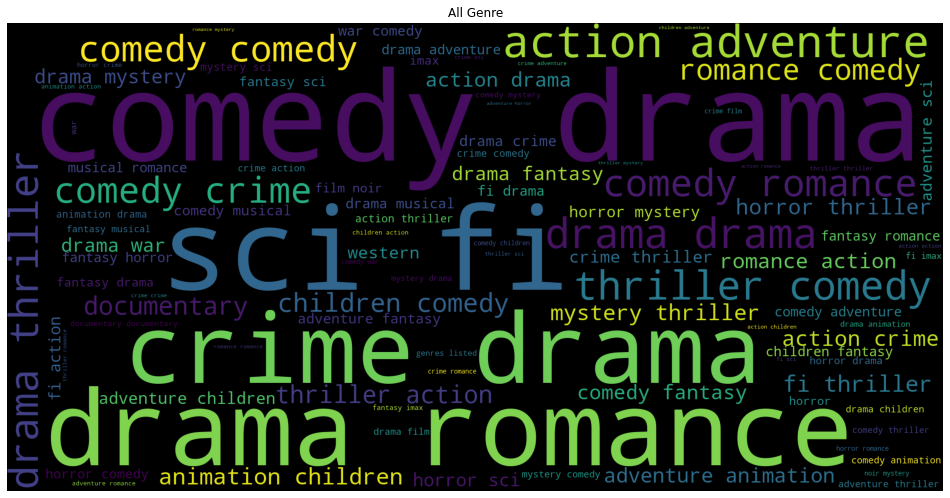

In [17]:
genres = movies.genres
stopwords = set(STOPWORDS)
comment_words = ''
for genre in genres:
 
    genre = str(genre)
    # split the different genres
    tokens = genre.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 2000, height = 1000, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words)
    
#Plot the wordcloud
plt.figure(figsize = (13, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title("All Genre")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Berdasarkan output diatas, didapatkan informasi bahwa:
- tidak terdapat nilai null ataupun duplikat pada dataset movies
- genre yang paling banyak muncul pada dataset movies diantaranya yaitu comedy, romance, drama, sci-fi

## Ratings

In [18]:
ratings.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [19]:
duplicate_rows_ratings = ratings[ratings.duplicated()]
print("number of duplicate rows: ", duplicate_rows_ratings.shape)

number of duplicate rows:  (0, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


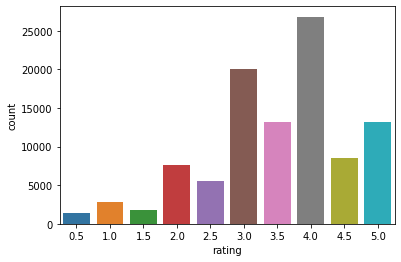

In [20]:
sns.countplot(ratings.rating)

Berdasarkan output diatas, didapatkan informasi bahwa:
- tidak terdapat nilai null atau duplikat pada dataset ratings
- rating terbanyak yang diberikan oleh user yaitu 4,0 dan disusul oleh rating 3,0. 
- rating tersedikit yang diberikan oleh user yaitu 0,5.

# Data Preparation

Pada tahap Data preparation data akan disiapkan sebelum melakukan modelling.Adapun persiapan yang dilakukan yaitu:
- *merge* dataset movies dengan dataset ratings, 
- pengecekan missing value pada dataframe hasil *merge* 
- mengurutkan dataframe sesuai dengan id dari movie
- Membuang file yang duplikat.
- Mengonversi data menjadi list.
- membuat dictionary dataframe.
- Membuang stopwords pada dataframe.

Hal yang akan dilakukan pertama yaitu melakukan *merge* atau menggabungkan dataset movies dengan dataset ratings. Kodenya yaitu sebagai berikut. 

In [21]:
new_movie = pd.merge(movies, ratings , on='movieId', how='left')
new_movie

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5
100851,193585,Flint (2017),Drama,184.0,3.5
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5


Selanjutnya, dilakukan pengecekan missing value pada dataframe hasil *merge* tadi

In [22]:
new_movie.isnull().sum()

movieId     0
title       0
genres      0
userId     18
rating     18
dtype: int64

berdasarkan output diatas, terdapat missing value pada dataframe baru yaitu new_movie, selanjutnya akan dihilangkan baris yang memiliki missing value tsb.

In [23]:
new_movie = new_movie.dropna()
new_movie

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5
100851,193585,Flint (2017),Drama,184.0,3.5
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5


In [24]:
new_movie.isnull().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

berdasarkan output diatas, dataframe new_movie telah bebas dari missing value. Selanjutnya akan diurutkan baris pada dataframe berdasarkan movieId.

In [25]:
new_movie = new_movie.sort_values('movieId', ascending=True)
new_movie

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
137,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,382.0,4.5
138,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,385.0,4.0
139,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,389.0,5.0
140,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,391.0,3.0
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5
100851,193585,Flint (2017),Drama,184.0,3.5
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5


Hal selanjutnya yaitu melihat apakah ada duplikasi pada movieId pada *dataframe* baru yang telah di *merge* sebelumnya.

In [26]:
duplicate_rows_new_movie = new_movie[new_movie['movieId'].duplicated()]
print("number of duplicate rows: ", duplicate_rows_new_movie.shape)

number of duplicate rows:  (91112, 5)


Berdasarkan output diatas, terdapat nilai duplikasi pada dataframe baru, selanjunya yaitu akan kita hapus nilai duplikat tersebut dan dimasukkan kedalam variabel preparation.

In [27]:
preparation = new_movie.drop_duplicates('movieId')

Hal selanjutnya yaitu menbuat dataframe movie_new yang berisi movie_id, movie_title dan movie_genre. Dataframe ini akan digunakan untuk menampilkan hasil rekomendasi menggunakan kedua jenis, yaitu content based dan collaborative.

In [28]:
movie_id = preparation['movieId'].tolist()
 
movie_title = preparation['title'].tolist()
 
movie_genre = preparation['genres'].tolist()
 
print(len(movie_id))
print(len(movie_title))
print(len(movie_genre))

9724
9724
9724


In [29]:
movie_new = pd.DataFrame({
    'Id': movie_id,
    'Title': movie_title,
    'Genre': movie_genre
})
movie_new

,Id,Title,Genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9721,193585,Flint (2017),Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Hal selanjutnya yaitu menbuat *dataframe* data dan membuat fungsi sanitize yang akan digunakan dalam proses *removing stop word*  atau *text cleaning*.

In [30]:
data = movie_new

In [31]:
def sanitize(x):
  try:
    if isinstance(x,list):
      return [i.replace(' ', ',').replace('|', ' ').replace('-','').lower() for i in x]  
    else:
      return [x.replace(' ','').lower()]
  except:
    print(x)

In [32]:
for i in data.Genre:
  data.Genre = data.Genre.apply(sanitize)

In [33]:
data.Genre

0       [adventure,animation,children,comedy,fantasy]
1                        [adventure,children,fantasy]
2                                    [comedy,romance]
3                              [comedy,drama,romance]
4                                            [comedy]
                            ...                      
9719                [action,animation,comedy,fantasy]
9720                       [animation,comedy,fantasy]
9721                                          [drama]
9722                               [action,animation]
9723                                         [comedy]
Name: Genre, Length: 9724, dtype: object

# **Model Developing**: Content Based Filtering

Algoritma Content Based Filtering adalah sistem yang merekomendasikan item yang mirip dengan item yang disukai pengguna di masa lalu.  Algoritma ini bekerja dengan menyarankan item serupa yang pernah disukai di masa lalu atau sedang dilihat di masa kini kepada pengguna. Semakin banyak informasi yang diberikan pengguna, semakin baik akurasi sistem rekomendasi. Kelebihan model ini yaitu sistem dapat merekomendasikan secara akurat item/film yang sesuai dengan user setelah user menonton film yang berkaitan dengan semakin banyaknya sample maka tingkat akurasinya akan sangat tinggi. Kelemahan dari sistem ini yaitu terbatasnya rekomendasi hanya terhadap item-item yang mirip sehingga tidak ada kesempatan untuk mendapatkan item yang tidak terduga.

Hal yang akan dilakukan pertama yaitu proses untuk menemukan representasi fitur penting dari setiap genre film menggunakan TF-IDF Vectorizer dari library sklearn. Kodenya yaitu sebagai berikut.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tf.fit(data['Genre'].astype(str)) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'filmnoir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'nogenreslisted',
 'romance',
 'scifi',
 'thriller',
 'war',
 'western']

Selanjutnya, dilakukan proses fit dan transformasi hasil sebelumnya ke dalam bentuk vektor. 

In [35]:
# Melakukan fit lalu ditransformasikan ke bentuk vektor
tfidf_matrix = tf.fit_transform(data['Genre'].astype(str)) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(9724, 20)

lalu, lakukan proses todense untuk mengubah vektor tf-idf dalam bentuk matriks.

In [36]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.41681721, 0.51634045, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51235785, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57836121, 0.        , 0.8157808 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Selanjutnya, buat dataframe baru untuk melihat hasil matriks tf-idf terhadap judul film dan beberapa genrenya.

In [37]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan judul film
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.Title
).sample(20, axis=1).sample(10, axis=0)

,romance,filmnoir,comedy,horror,drama,fantasy,thriller,western,documentary,adventure,musical,nogenreslisted,imax,action,children,mystery,crime,war,scifi,animation
Title,,,,,,,,,,,,,,,,,,,,
DeadHeads (2011),0.000000,0.0,0.399019,0.673989,0.000000,0.000000,0.000000,0.0,0.0,0.621709,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Ethan Frome (1993),0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Phineas and Ferb the Movie: Across the 2nd Dimension (2011),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.499945,0.0,0.0,0.0,0.000000,0.605394,0.0,0.000000,0.0,0.0,0.619316
Whipped (2000),0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
In China They Eat Dogs (I Kina spiser de hunde) (1999),0.000000,0.0,0.590025,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.807385,0.000000,0.0,0.000000,0.0,0.0,0.000000
Happy Gilmore (1996),0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Made in Heaven (1987),0.623362,0.0,0.000000,0.000000,0.000000,0.781933,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
[REC] (2007),0.000000,0.0,0.000000,0.717986,0.392977,0.000000,0.574513,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
Meet John Doe (1941),0.000000,0.0,0.734280,0.000000,0.678847,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


Berdasarkan output diatas, didapatkan informasi bahwa film **Feds (1988)** merupakan film dengan genre comedy, dibuktikan dengan nilai tf-idf yaitu 1. Terdapat pula film **Dear John (2010)** merupakan film dengan genre war, romance dan drama.

Langkah selanjutnya yaitu menghitung derajat kesamaan (*similarity degree*) antar film dengan teknik cosine similarity dari library sklearn. Kodenya yaitu sebagai berikut. 

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
        0.26751731],
       [0.81352752, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57053212],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42122062, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26751731, 0.        , 0.57053212, ..., 0.        , 0.        ,
        1.        ]])

Selanjutnya, buat dataframe untuk melihat matriks kesamaan setiap film. Kodenya yaitu sebagai berikut.

In [39]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['Title'], columns=data['Title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


Title,Dumb and Dumberer: When Harry Met Lloyd (2003),Ménage (Tenue de soirée) (1986),Doctor Who: The Time of the Doctor (2013),Viridiana (1961),Chill Factor (1999)
Title,,,,,
Like Mike (2002),0.357595,0.262575,0.000000,0.262575,0.133949
Restoration (1995),0.000000,0.678847,0.510289,0.678847,0.000000
Smiley's People (1982),0.000000,0.289347,0.217502,0.289347,0.000000
Hesher (2010),0.000000,0.678847,0.510289,0.678847,0.000000
Heat (1995),0.000000,0.000000,0.000000,0.000000,0.555905
Azumi (2003),0.000000,0.237522,0.685670,0.237522,0.868586
Wonder (2017),0.000000,0.678847,0.510289,0.678847,0.000000
Nerve (2016),0.000000,0.383260,0.288097,0.383260,0.417875
Mr. Brooks (2007),0.000000,0.275337,0.206971,0.275337,0.300204


Berdasarkan informasi diatas, terdapat film yang memiliki nilai cosine similarity paling tinggi, yaitu film **Out Cold (2001)** dan film **Berlin Calling (2000)** dengan nilai cosine similarity sekitar 0.7. 

Selanjutnya, definikasn fungsi movie_recommendation untuk mendapatkan rekomendasi film berdasarkan user yang telah memberikan rating film sebelumnya. Ambil contoh si A telah memberikan rating yang bagus untuk film **Men In Black**, maka A akan mendapatkan rekomendasi film yang mirip dengan film **Men In Black** berdasarkan kesamaan yang dihitung dengan cosine similarity pada tahap sebelumnya

In [40]:
def movie_recommendations(judul_film, similarity_data=cosine_sim_df, items=data[['Title', 'Genre']], k=7):
    """
    Rekomendasi movies berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    judul_film : tipe data string (str)
                judul film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan film sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_film].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop judul film agar judul film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_film, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

Selanjutnya, terapkan kode untuk menemukan rekomendasi film yang mirip dengan film **Frequency (2000)**. 

In [41]:
data[data.Title.eq('Frequency (2000)')]

,Id,Title,Genre
2620,3510,Frequency (2000),"[drama,thriller]"


Berdasarkan output diatas, didapatkan informasi bahwa Film **Frequency (2000)** ternyata merupakan film dengan genre drama dan thriller.

Terakhir, kita jalankan fungsi movie_recommendations untuk mendapatkan rekomendasi film **Frequency (2000)**.

In [42]:
# Mendapatkan rekomendasi film yang mirip dengan Frequency
movie_recommendations('Frequency (2000)')

,Title,Genre
0,Instinct (1999),"[drama,thriller]"
1,Escape from Alcatraz (1979),"[drama,thriller]"
2,Black Swan (2010),"[drama,thriller]"
3,Syriana (2005),"[drama,thriller]"
4,City Hall (1996),"[drama,thriller]"
5,Some Folks Call It a Sling Blade (1993),"[drama,thriller]"
6,Cherrybomb (2009),"[drama,thriller]"


Seperti yang dilihat pada output diatas, sistem berhasil memberikan rekomendasi film yang mirip dengan film **Frequency (2000)** menggunakan algoritma *content based filtering*. Mari lanjutkan ke algoritma selanjutnya yaitu *collaborative filtering*.

# **Model Developing**: *Collaborative Filtering*

Algoritma *Collaborative Filtering* adalah Algoritma yang bergantung pada pendapat komunitas pengguna. Ia tidak memerlukan atribut untuk setiap itemnya seperti pada algoritma sebelumnya. *Collaborative filtering* dibagi lagi menjadi dua kategori, yaitu: *model based* (metode berbasis model ML) dan *memory based* (metode berbasis memori). Kelebihan algoritma ini yaitu rekomendasi tetap akan berkerja dalam keadaan dimana konten sulit dianalisi sekalipun sedangkan kekurangannya yaitu membutuhkan parameter rating, sehingga jika ada item baru sistem tidak akan merekomendasikan item tersebut.

Hal yang akan dilakukan pertama kali untuk menerapkan algoritma ini yaitu mendefinisikan variabel df yang mengambil dari dataset ratings.csv yang telah melewati proses EDA.

In [43]:
# Membaca dataset
 
df = ratings
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Langkah selanjutnya yaitu cek beberapa hal dalam data seperti jumlah user, jumlah film, mengubah nilai rating menjadi float32 .

In [44]:
# Mendapatkan jumlah user
num_users = len(df.userId.unique())
print(num_users)
 
# Mendapatkan jumlah movie
num_movie = len(df.movieId.unique())
print(num_movie)
 
# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9724
Number of User: 610, Number of movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Langkah berikutnya yaitu acak dataset terlebih dahulu agar distribusinya menjadi random dan lakukan split dataset menjadi data training dan data testing.

In [45]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


In [46]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['userId', 'movieId']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  432 77866]
 [  288   474]
 [  599  4351]
 ...
 [  480  6867]
 [    6   981]
 [  103  6711]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Selanjutnya, buat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai kasus yang sedang kita selesaikan. Terapkan kode berikut.

In [49]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Selanjutnya, lakukan proses compile terhadap model menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation. .

In [50]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Langkah selanjutnya, mulailah proses training. 

In [51]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 512,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
158/158 [==============================] - 5s 7ms/step - loss: 0.6597 - root_mean_squared_error: 0.2553 - val_loss: 0.6339 - val_root_mean_squared_error: 0.2286
Epoch 2/50
158/158 [==============================] - 1s 4ms/step - loss: 0.6812 - root_mean_squared_error: 0.2602 - val_loss: 0.7153 - val_root_mean_squared_error: 0.3037
Epoch 3/50
158/158 [==============================] - 1s 5ms/step - loss: 0.7677 - root_mean_squared_error: 0.3413 - val_loss: 0.6543 - val_root_mean_squared_error: 0.2456
Epoch 4/50
158/158 [==============================] - 1s 5ms/step - loss: 0.6753 - root_mean_squared_error: 0.2528 - val_loss: 0.6867 - val_root_mean_squared_error: 0.2793
Epoch 5/50
158/158 [==============================] - 1s 4ms/step - loss: 0.6418 - root_mean_squared_error: 0.2374 - val_loss: 0.6596 - val_root_mean_squared_error: 0.2542
Epoch 6/50
158/158 [==============================] - 1s 5ms/step - loss: 0.6291 - root_mean_squared_error: 0.2246 - val_loss: 0.6710 - val_

Langkah berikutnya, visualisasikan proses training dengan library matplotlib. Terapkan kode berikut.

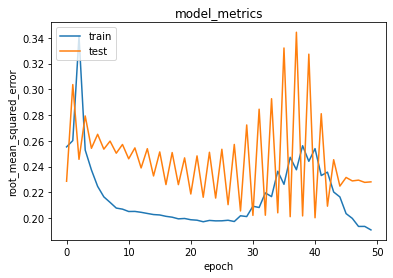

In [52]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan informasi diatas, proses training telah dilakukan dengan cukup baik. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.19 dan error pada data validasi sekitar 0.23 Nilai tersebut cukup bagus untuk sistem rekomendasi.

Selanjutnya yaitu ambil sampel user secara acak dan definisikan variabel movie_not_view yang merupakan daftar film yang belum pernah dilihat oleh user. Kodenya yaitu sebagai berikut.

In [53]:
movie_df = movie_new
df = pd.read_csv('ratings.csv')
 
# Mengambil sample user
user_id = df['userId'].sample(1).iloc[0]
movie_view_by_user = df[df['userId'] == user_id]
 
movie_not_view = movie_df[~movie_df['Id'].isin(movie_view_by_user.movieId.values)]['Id'] 
movie_not_view = list(
    set(movie_not_view)
    .intersection(set(df.movieId.keys()))
)
 
movie_not_view = [[df.movieId.get(x)] for x in movie_not_view]
user_encoder = df.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_view), movie_not_view)
)
user_movie_array = np.asarray(user_movie_array).astype(np.float32)

Selanjutnya, untuk memperoleh rekomendasi film, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [54]:
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    df.movieId.get(movie_not_view[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_view_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['Id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.Title, ':', row.Genre)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['Id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.Title, ':', row.Genre)

Showing recommendations for users: 610
movie with high ratings from user
--------------------------------
Toy Story (1995) : ['adventure,animation,children,comedy,fantasy']
Blue Velvet (1986) : ['drama,mystery,thriller']
Bourne Ultimatum, The (2007) : ['action,crime,thriller']
In Bruges (2008) : ['comedy,crime,drama,thriller']
John Wick (2014) : ['action,thriller']
--------------------------------
Top 10 movie recommendation
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : ['action,adventure,scifi']


Berdasarkan output diatas, model yang dihasilkan bisa memberikan rekomendasi film dengan cukup bagus. Hal ini bisa dibuktikan dengan film yang diberikan oleh sistem cukup sesuai dengan genre film yang diberikan rating tinggi oleh user. 

Begitulah kedua model yang telah dibuat. Semoga kedua model yang telah dibuat ini bisa membantu pengguna untuk mendapatkan rekomendasi film yang diinginkan.